In [1]:
try:
    import davos
except ImportError:
    %pip install davos
    import davos

davos.config.suppress_stdout = True

In [2]:
smuggle nltools as nlt            # pip: nltools==0.4.7

smuggle nilearn as nl             # pip: nilearn==0.10.0
smuggle nibabel as nib            # pip: nibabel==5.0.1

smuggle datawrangler as dw        # pip: pydata-wrangler==0.2.2

smuggle numpy as np               # pip: numpy==1.24.2
smuggle matplotlib.pyplot as plt  # pip: matplotlib==3.7.0
smuggle matplotlib as mpl
from matplotlib.colors smuggle ListedColormap, hex2color, rgb2hex
from matplotlib.ticker smuggle FormatStrFormatter
from matplotlib.lines import Line2D
smuggle matplotlib
from matplotlib smuggle rc

smuggle pandas as pd              # pip: pandas==1.5.3
smuggle seaborn as sns            # pip: seaborn==0.12.2
from skimage smuggle transform    # pip: scikit-image==0.20.0

from sklearn.decomposition smuggle IncrementalPCA as PCA     # pip: scikit-learn==1.2.1
from scipy.spatial.distance smuggle pdist, squareform        # pip: scipy==1.10.1
from scipy.io smuggle loadmat
from scipy.stats smuggle spearmanr, pearsonr, ttest_ind, ttest_1samp
from tqdm smuggle tqdm            # pip: tqdm==4.64.1
smuggle jinja2 as j2              # pip: jinja2==3.1.2
smuggle networkx as nx            # pip: networkx==3.0

from sklearn.linear_model smuggle LinearRegression           # pip: scikit-learn==1.2.1
from statsmodels.stats.multitest smuggle multipletests       # pip: statsmodels==0.14.0

smuggle requests                  # pip: requests==2.28.2

from datetime import datetime as dt
import os
import shutil
import pickle
import warnings
from glob import glob as lsdir

from helpers import nii2cmu, cmu2nii, conditions, condition_colors, figdir, basedir, datadir, scratch_dir, group_pca, get_data, rbf, pstring

# set random seed
np.random.seed(123)

Fetch/load the HTFA posterior

In [3]:
data = get_data()

Compute temporal autocorrelations for each participant/condition as a function of lag

In [4]:
def r2z(r):
    return np.arctanh(r)

def z2r(z):
    return np.tanh(z)

def autocorrelation(M, axis=0, lag=1):
    def helper(x, lag):
        return np.corrcoef(x[:-lag], x[lag:])[0, 1]

    return np.apply_along_axis(helper, axis, M, lag=lag)

In [5]:
temporal_autocorrelations_fname = os.path.join(scratch_dir, 'temporal_autocorrelations.pkl')
if os.path.exists(temporal_autocorrelations_fname):
    with open(temporal_autocorrelations_fname, 'rb') as f:
        temporal_autocorrelations = pickle.load(f)
else:
    temporal_autocorrelations = []
    for condition in data['weights'].keys():
        cdata = data['weights'][condition]
        for subj in tqdm(range(len(cdata))):
            for lag in range(1, np.min([cdata[subj].shape[0] - 2, 100])):
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    temporal_autocorrelations.append(pd.DataFrame.from_records([{
                        'Condition': condition,
                        'Participant ID': subj,
                        'Lag': lag,
                        'Temporal autocorrelation': z2r(np.mean(r2z(autocorrelation(cdata[subj], axis=0, lag=lag)))) # axis=0 computes autocorrelation for each node
                    }]))

    temporal_autocorrelations = pd.concat(temporal_autocorrelations, axis=0, ignore_index=True)
    with open(temporal_autocorrelations_fname, 'wb') as f:
        pickle.dump(temporal_autocorrelations, f)

In [6]:
temporal_autocorrelations

,Condition,Participant ID,Lag,Temporal autocorrelation
0,intact,0,1,0.499943
1,intact,0,2,0.327606
2,intact,0,3,0.191101
3,intact,0,4,0.090312
4,intact,0,5,0.072966
...,...,...,...,...
12370,rest,35,95,0.002097
12371,rest,35,96,0.008456
12372,rest,35,97,0.008101
12373,rest,35,98,0.002317


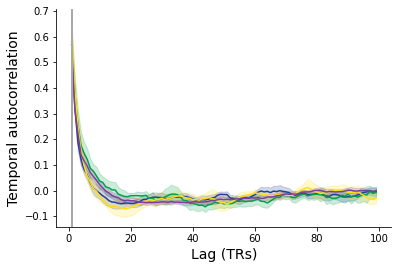

In [7]:
sns.lineplot(temporal_autocorrelations, x='Lag', y='Temporal autocorrelation', hue='Condition', palette=condition_colors, legend=False)
ylim = plt.gca().get_ylim()
plt.plot([1, 1], ylim, '-', color='darkgray', lw=2)
plt.ylim(ylim)

plt.xlabel('Lag (TRs)', fontsize=14)
plt.ylabel('Temporal autocorrelation', fontsize=14)
sns.despine(top=True, right=True)

plt.savefig(os.path.join(figdir, 'temporal_autocorrelations.pdf'), bbox_inches='tight')

Lag 0 only

In [8]:
temporal_autocorrelations.query('Lag == 1')

,Condition,Participant ID,Lag,Temporal autocorrelation
0,intact,0,1,0.499943
99,intact,1,1,0.637069
198,intact,2,1,0.705697
297,intact,3,1,0.585176
396,intact,4,1,NaN
...,...,...,...,...
11880,rest,31,1,0.615159
11979,rest,32,1,0.529038
12078,rest,33,1,NaN
12177,rest,34,1,NaN


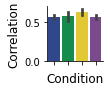

In [9]:
plt.figure(figsize=(1, 1))
sns.barplot(temporal_autocorrelations.query('Lag == 1'), x='Condition', y='Temporal autocorrelation', palette=condition_colors)
plt.gca().set_xticklabels(['' for _ in plt.gca().get_xticklabels()])

plt.xlabel('Condition', fontsize=12)
plt.ylabel('Correlation', fontsize=12)
sns.despine(top=True, right=True)

plt.savefig(os.path.join(figdir, 'temporal_autocorrelations_inset.pdf'), bbox_inches='tight')

In [10]:
def compare_conds(x, conds, metric):
    for i, c1 in enumerate(conds):
        c1_data = x.query(f'Condition == "{c1}"')[metric]
        for c2 in conds[i + 1:]:
            c2_data = x.query(f'Condition == "{c2}"')[metric]
            results = ttest_ind(c1_data, c2_data, nan_policy='omit')
            print(f'{c1} vs. {c2}: t({len(c1_data) + len(c2_data) - np.sum(np.isnan(c1_data)) - np.sum(np.isnan(c2_data) - 2)}) = {results.statistic:.2f}, {pstring(results.pvalue)}')
            

In [11]:
compare_conds(temporal_autocorrelations.query('Lag == 1'), conditions, 'Temporal autocorrelation')

intact vs. paragraph: t(60) = -0.45, p = 0.659
intact vs. word: t(106) = -2.63, p = 0.013
intact vs. rest: t(106) = -0.07, p = 0.944
paragraph vs. word: t(94) = -1.34, p = 0.195
paragraph vs. rest: t(94) = 0.41, p = 0.686
word vs. rest: t(102) = 2.52, p = 0.018


Compute spatial autocorrelation as a function of distance

In [12]:
spatial_autocorrelations_fname = os.path.join(scratch_dir, 'spatial_autocorrelations.pkl')

if os.path.exists(spatial_autocorrelations_fname):
    with open(spatial_autocorrelations_fname, 'rb') as f:
        spatial_autocorrelations = pickle.load(f)
else:
    # Euclidean distance between each pair of HTFA centers
    dists = squareform(pdist(data['centers']))
    spatial_autocorrelations = []
    for condition in data['weights'].keys():
        cdata = data['weights'][condition]
        for subj in tqdm(range(len(cdata))):
            for i in range(cdata[subj].shape[1]):
                for j in range(i + 1, cdata[subj].shape[1]):
                    with warnings.catch_warnings():
                        warnings.simplefilter('ignore')
                        spatial_autocorrelations.append(pd.DataFrame.from_records([{
                            'Condition': condition,
                            'Participant ID': subj,
                            'Node 1': i,
                            'Node 2': j,
                            'Distance': dists[i, j],
                            'Spatial autocorrelation': np.corrcoef(cdata[subj].iloc[:, i], cdata[subj].iloc[:, j])[0, 1]
                        }]))

    spatial_autocorrelations = pd.concat(spatial_autocorrelations, axis=0, ignore_index=True)
    with open(spatial_autocorrelations_fname, 'wb') as f:
        pickle.dump(spatial_autocorrelations, f)
    
spatial_autocorrelations['Distance bin'] = pd.cut(spatial_autocorrelations['Distance'], bins=100)
spatial_autocorrelations['Bin midpoint'] = spatial_autocorrelations['Distance bin'].apply(lambda x: x.mid)

# use groupby so that error ribbons are computed across participants
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    spatial_autocorrelations = spatial_autocorrelations.groupby(['Condition', 'Participant ID', 'Bin midpoint']).mean().reset_index().drop(columns=['Node 1', 'Node 2', 'Bin midpoint'])

In [13]:
spatial_autocorrelations

,Condition,Participant ID,Distance,Spatial autocorrelation
0,intact,0,3.805810,0.077221
1,intact,0,5.839426,0.089366
2,intact,0,7.438476,0.103628
3,intact,0,9.005955,0.204890
4,intact,0,10.557228,0.267297
...,...,...,...,...
14395,word,35,159.813524,0.098226
14396,word,35,161.360423,0.104180
14397,word,35,162.914496,0.156676
14398,word,35,164.719152,0.087538


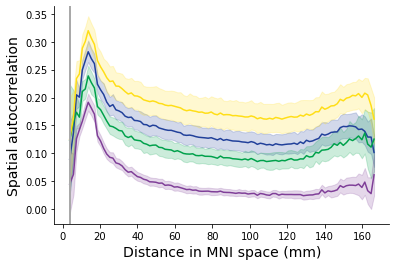

In [14]:
sns.lineplot(spatial_autocorrelations, x='Distance', y='Spatial autocorrelation', hue='Condition', palette=condition_colors, legend=False)
ylim = plt.gca().get_ylim()
plt.plot([spatial_autocorrelations['Distance'].min(), spatial_autocorrelations['Distance'].min()], ylim, '-', color='darkgray', lw=2)
plt.ylim(ylim)


plt.xlabel('Distance in MNI space (mm)', fontsize=14)
plt.ylabel('Spatial autocorrelation', fontsize=14)
sns.despine(top=True, right=True)

plt.savefig(os.path.join(figdir, 'spatial_autocorrelations.pdf'), bbox_inches='tight')

Spatial autocorrelation inset

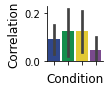

In [15]:
plt.figure(figsize=(1, 1))
threshold = spatial_autocorrelations['Distance'].quantile(q=0.01, interpolation='linear')
sns.barplot(spatial_autocorrelations.query('Distance < @threshold'), x='Condition', y='Spatial autocorrelation', palette=condition_colors, order=conditions)
plt.gca().set_xticklabels(['' for _ in plt.gca().get_xticklabels()])

plt.ylim([0, plt.gca().get_ylim()[1]])
plt.xlabel('Condition', fontsize=12)
plt.ylabel('Correlation', fontsize=12)
sns.despine(top=True, right=True)

plt.savefig(os.path.join(figdir, 'spatial_autocorrelations_inset.pdf'), bbox_inches='tight')

In [16]:
compare_conds(spatial_autocorrelations.query('Distance < @threshold'), conditions, 'Spatial autocorrelation')

intact vs. paragraph: t(87) = -0.58, p = 0.562
intact vs. word: t(144) = -0.68, p = 0.500
intact vs. rest: t(144) = 1.03, p = 0.308
paragraph vs. word: t(125) = -0.03, p = 0.978
paragraph vs. rest: t(125) = 1.46, p = 0.152
word vs. rest: t(144) = 1.58, p = 0.118
